In [1]:
"""
Author: Alan, Chen
Email: alanchen0922@gmail.com

paper: https://arxiv.org/abs/1611.08024
"""

'\nAuthor: Alan, Chen\nEmail: alanchen0922@gmail.com\n\npaper: https://arxiv.org/abs/1611.08024\n'

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Function
from torch.nn.modules.module import Module
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import numpy as np

from torchsummary import summary


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [7]:
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label

In [8]:
class DepthwiseConv2d(torch.nn.Conv2d):
    def __init__(self,
                 in_channels,
                 depth_multiplier=1,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 dilation=1,
                 bias=True,
                 padding_mode='zeros'
                 ):
        out_channels = in_channels * depth_multiplier
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=in_channels,
            bias=bias,
            padding_mode=padding_mode
        )
        
      ## conv with max norm  
#     def forward(self, x):
#     return F.conv2d(x, self.weight.clamp(min=-1.0, max=1.0), self.bias, self.stride,
#                     self.padding, self.dilation, self.groups)

In [9]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, groups=in_channels, bias=bias, padding=padding)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, bias=bias)
    
    def forward(self,x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [39]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.C = 2
        self.T = 750
        self.F1 = 16
        self.D = 2
        self.F2 = 32
        self.kernel_length = 64
        self.dropoutRate = 0.2
        self.classes = 2
        
        # block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.F1, kernel_size=(1, 51), padding=(0, 25), stride=(1, 1), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(self.F1)
        self.depthwise1 = DepthwiseConv2d(self.F1, kernel_size=(self.C, 1), depth_multiplier=self.D, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(self.F1*self.D)
        self.relu1 = nn.ReLU()
#         self.lrelu1 = nn.LeakyReLU()
        self.averagePooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(p=self.dropoutRate)
        
        # block 2
        self.separableconv1 = SeparableConv2d(self.F1*self.D, self.F2, kernel_size=(1, 15), padding=(0, 7), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(self.F2)
        self.relu2 = nn.ReLU()
#         self.lrelu2 = nn.LeakyReLU()
        self.averagePooling2 = nn.AvgPool2d(kernel_size=(1,8))
        self.dropout2 = nn.Dropout(p=self.dropoutRate)
        self.flatten1 = nn.Flatten()
        
        self.dense1 = nn.Linear(self.F2*(self.T//32), self.classes)
        
        
    def forward(self, x):
        
        ## block 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwise1(x)
        x = self.batchnorm2(x)
#         x = self.lrelu1(x)
        x = self.relu1(x)
#         x = F.elu(x) #activation
        x = self.averagePooling1(x)
        x = self.dropout1(x)
        
        ## block 2
        x = self.separableconv1(x)
        x = self.batchnorm3(x)
#         x = self.lrelu2(x)
        x = self.relu2(x)
#         x = F.elu(x) #activation
        x = self.averagePooling2(x)
        x = self.dropout2(x)
        x = self.flatten1(x)
        x = self.dense1(x)
#         x = F.softmax(x, dim=1)
        
        return x
    
model = EEGNet().to(device)
# print(model)
summary(model, (1, 2, 750))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 2, 750]             816
       BatchNorm2d-2           [-1, 16, 2, 750]              32
   DepthwiseConv2d-3           [-1, 32, 1, 750]              64
       BatchNorm2d-4           [-1, 32, 1, 750]              64
         AvgPool2d-5           [-1, 32, 1, 187]               0
           Dropout-6           [-1, 32, 1, 187]               0
            Conv2d-7           [-1, 32, 1, 187]             480
            Conv2d-8           [-1, 32, 1, 187]           1,024
   SeparableConv2d-9           [-1, 32, 1, 187]               0
      BatchNorm2d-10           [-1, 32, 1, 187]              64
        AvgPool2d-11            [-1, 32, 1, 23]               0
          Dropout-12            [-1, 32, 1, 23]               0
          Flatten-13                  [-1, 736]               0
           Linear-14                   

In [29]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avg_loss, avg_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        avg_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader.dataset)
    return 100*avg_acc, avg_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return 100*correct, test_loss

In [30]:
from sklearn import preprocessing

x_train, y_train, x_test, y_test = read_bci_data()

x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).type(torch.LongTensor).to(device)

x_test = torch.from_numpy(x_test).float().to(device)
y_test = torch.from_numpy(y_test).type(torch.LongTensor).to(device) # data type is long

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

batch_size = 128
train_loader = DataLoader(
    dataset=train,
    batch_size=batch_size,
    shuffle=True,
)

test_loader = DataLoader(
    dataset=test,
    batch_size=batch_size,
    shuffle=True,
)

epochs = 2000
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.02)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


In [31]:
train_acc = []
train_loss = []
test_acc = []
test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_acc, tr_loss = train_loop(train_loader, model, loss_fn, optimizer)
    te_acc, te_loss = test_loop(test_loader, model, loss_fn)
    train_acc.append(tr_acc)
    train_loss.append(tr_loss)
    test_acc.append(te_acc)
    test_loss.append(te_loss)
    if te_acc > 88.5 and t > 300:
        break
print("Done!")

print("Saving model weight...")
torch.save(model, "./EEGNet_model.pt")
print("Save Done!")

Epoch 1
-------------------------------
loss: 0.719906  [    0/ 1080]
Test Error: 
 Accuracy: 61.6%, Avg loss: 0.647258 

Epoch 2
-------------------------------
loss: 0.640274  [    0/ 1080]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.608545 

Epoch 3
-------------------------------
loss: 0.617975  [    0/ 1080]
Test Error: 
 Accuracy: 69.3%, Avg loss: 0.592065 

Epoch 4
-------------------------------
loss: 0.561945  [    0/ 1080]
Test Error: 
 Accuracy: 70.6%, Avg loss: 0.562735 

Epoch 5
-------------------------------
loss: 0.513733  [    0/ 1080]
Test Error: 
 Accuracy: 71.6%, Avg loss: 0.558456 

Epoch 6
-------------------------------
loss: 0.547534  [    0/ 1080]
Test Error: 
 Accuracy: 71.1%, Avg loss: 0.542275 

Epoch 7
-------------------------------
loss: 0.503406  [    0/ 1080]
Test Error: 
 Accuracy: 71.9%, Avg loss: 0.541887 

Epoch 8
-------------------------------
loss: 0.516511  [    0/ 1080]
Test Error: 
 Accuracy: 71.7%, Avg loss: 0.534345 

Epoch 9
----------------

Test Error: 
 Accuracy: 84.4%, Avg loss: 0.340685 

Epoch 69
-------------------------------
loss: 0.183292  [    0/ 1080]
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.345700 

Epoch 70
-------------------------------
loss: 0.203623  [    0/ 1080]
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.334780 

Epoch 71
-------------------------------
loss: 0.168427  [    0/ 1080]
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.345784 

Epoch 72
-------------------------------
loss: 0.158493  [    0/ 1080]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.342876 

Epoch 73
-------------------------------
loss: 0.187209  [    0/ 1080]
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.328879 

Epoch 74
-------------------------------
loss: 0.200788  [    0/ 1080]
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.345040 

Epoch 75
-------------------------------
loss: 0.192107  [    0/ 1080]
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.337174 

Epoch 76
-------------------------------
loss: 0.158285  [    0/ 1080]
Test Error: 
 Ac

Test Error: 
 Accuracy: 85.2%, Avg loss: 0.330626 

Epoch 137
-------------------------------
loss: 0.180417  [    0/ 1080]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.307212 

Epoch 138
-------------------------------
loss: 0.181356  [    0/ 1080]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.335675 

Epoch 139
-------------------------------
loss: 0.178214  [    0/ 1080]
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.299976 

Epoch 140
-------------------------------
loss: 0.164354  [    0/ 1080]
Test Error: 
 Accuracy: 87.4%, Avg loss: 0.301053 

Epoch 141
-------------------------------
loss: 0.204248  [    0/ 1080]
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.315079 

Epoch 142
-------------------------------
loss: 0.136049  [    0/ 1080]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.320410 

Epoch 143
-------------------------------
loss: 0.140311  [    0/ 1080]
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.313642 

Epoch 144
-------------------------------
loss: 0.170276  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 86.1%, Avg loss: 0.322160 

Epoch 205
-------------------------------
loss: 0.197460  [    0/ 1080]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.304810 

Epoch 206
-------------------------------
loss: 0.140110  [    0/ 1080]
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.313609 

Epoch 207
-------------------------------
loss: 0.146137  [    0/ 1080]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.320132 

Epoch 208
-------------------------------
loss: 0.189242  [    0/ 1080]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.316245 

Epoch 209
-------------------------------
loss: 0.163666  [    0/ 1080]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.335227 

Epoch 210
-------------------------------
loss: 0.110465  [    0/ 1080]
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.313538 

Epoch 211
-------------------------------
loss: 0.220006  [    0/ 1080]
Test Error: 
 Accuracy: 87.7%, Avg loss: 0.308586 

Epoch 212
-------------------------------
loss: 0.138244  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 87.1%, Avg loss: 0.317241 

Epoch 273
-------------------------------
loss: 0.182977  [    0/ 1080]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.311497 

Epoch 274
-------------------------------
loss: 0.144965  [    0/ 1080]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.321079 

Epoch 275
-------------------------------
loss: 0.168961  [    0/ 1080]
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.324794 

Epoch 276
-------------------------------
loss: 0.148553  [    0/ 1080]
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.315466 

Epoch 277
-------------------------------
loss: 0.151670  [    0/ 1080]
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.324259 

Epoch 278
-------------------------------
loss: 0.147327  [    0/ 1080]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.333093 

Epoch 279
-------------------------------
loss: 0.143615  [    0/ 1080]
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.318810 

Epoch 280
-------------------------------
loss: 0.166776  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 86.1%, Avg loss: 0.313191 

Epoch 341
-------------------------------
loss: 0.126750  [    0/ 1080]
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.307076 

Epoch 342
-------------------------------
loss: 0.168961  [    0/ 1080]
Test Error: 
 Accuracy: 87.2%, Avg loss: 0.305474 

Epoch 343
-------------------------------
loss: 0.165366  [    0/ 1080]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.324113 

Epoch 344
-------------------------------
loss: 0.164359  [    0/ 1080]
Test Error: 
 Accuracy: 87.7%, Avg loss: 0.300162 

Epoch 345
-------------------------------
loss: 0.155543  [    0/ 1080]
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.319222 

Epoch 346
-------------------------------
loss: 0.149300  [    0/ 1080]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.320512 

Epoch 347
-------------------------------
loss: 0.153175  [    0/ 1080]
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.316266 

Epoch 348
-------------------------------
loss: 0.125570  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 87.1%, Avg loss: 0.299742 

Epoch 409
-------------------------------
loss: 0.114154  [    0/ 1080]
Test Error: 
 Accuracy: 87.2%, Avg loss: 0.301931 

Epoch 410
-------------------------------
loss: 0.149996  [    0/ 1080]
Test Error: 
 Accuracy: 85.9%, Avg loss: 0.320200 

Epoch 411
-------------------------------
loss: 0.137504  [    0/ 1080]
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.315023 

Epoch 412
-------------------------------
loss: 0.145806  [    0/ 1080]
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.301689 

Epoch 413
-------------------------------
loss: 0.148976  [    0/ 1080]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.325154 

Epoch 414
-------------------------------
loss: 0.159450  [    0/ 1080]
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.289375 

Epoch 415
-------------------------------
loss: 0.140946  [    0/ 1080]
Test Error: 
 Accuracy: 87.7%, Avg loss: 0.318878 

Epoch 416
-------------------------------
loss: 0.127472  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 86.9%, Avg loss: 0.319287 

Epoch 477
-------------------------------
loss: 0.176288  [    0/ 1080]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.322144 

Epoch 478
-------------------------------
loss: 0.150437  [    0/ 1080]
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.303903 

Epoch 479
-------------------------------
loss: 0.132540  [    0/ 1080]
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.300391 

Epoch 480
-------------------------------
loss: 0.122872  [    0/ 1080]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.314480 

Epoch 481
-------------------------------
loss: 0.142970  [    0/ 1080]
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.318778 

Epoch 482
-------------------------------
loss: 0.155783  [    0/ 1080]
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.312867 

Epoch 483
-------------------------------
loss: 0.143122  [    0/ 1080]
Test Error: 
 Accuracy: 87.6%, Avg loss: 0.324409 

Epoch 484
-------------------------------
loss: 0.145252  [    0/ 1080]
Test Err

In [32]:
# elu_train 
# elu_test 
relu_train = train_acc
relu_test = test_acc
# leakyrelu_train = train_acc
# leakyrelu_test = test_acc

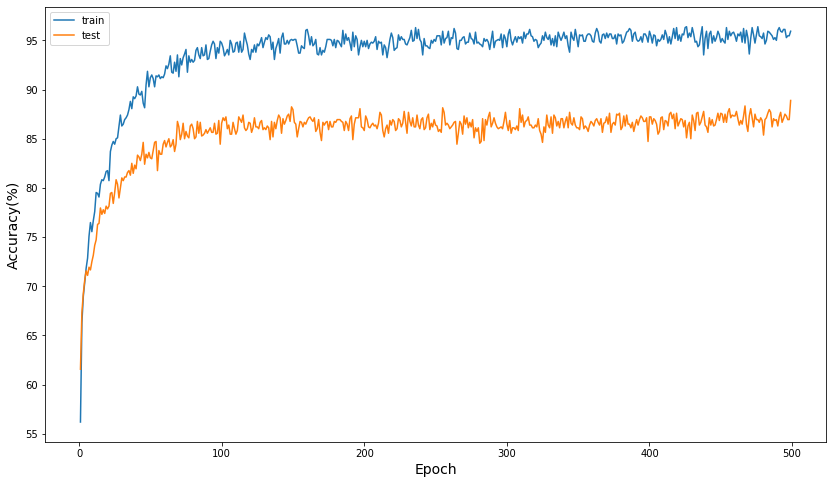

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))

# plt.title("Activation Function comparision(EEGNet)", fontsize=18)
plt.ylabel("Accuracy(%)", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
x = np.arange(1, len(train_acc)+1)
# plt.plot(x, elu_train, label='elu_train')
# plt.plot(x, elu_test, label="elu_test")
# x_relu = np.arange(1, len(relu_train)+1)
# plt.plot(x_relu, relu_train, label="relu_train")
# plt.plot(x_relu, relu_test, label="relu_test")
# plt.plot(x, leakyrelu_train, label="leakyReLU_train")
# plt.plot(x, leakyrelu_test, label="leakyReLU_test")
plt.plot(x, train_acc, label="train")
plt.plot(x, test_acc, label="test")
plt.legend()
plt.show()

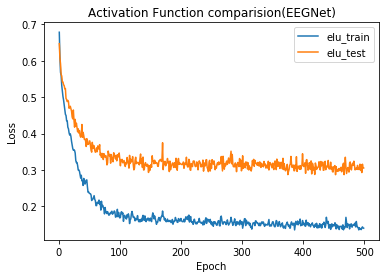

In [34]:
plt.figure()

plt.title("Activation Function comparision(EEGNet)")
plt.ylabel("Loss")
plt.xlabel("Epoch")
x = np.arange(1, len(train_loss)+1)
plt.plot(x, train_loss, label="elu_train")
plt.plot(x, test_loss, label="elu_test")
plt.legend()
plt.show()

In [35]:
print(max(test_acc))

88.88888888888889


In [40]:
# model_load = EEGNet().to(device)
# model_load.load_state_dict(torch.load(".\EEGNet_weight.pt"))
model_load = torch.load('EEGNet_model_85_elu.pt', map_location=device)
model_load.eval()

test_loss, correct = 0, 0
pred = model_load(x_test)
test_loss += loss_fn(pred, y_test).item()
correct += (pred.argmax(1) == y_test).type(torch.float).sum().item()

correct /= len(x_test)

print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
print(model_load)
summary(model_load, (1, 2, 750))

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.360531 

EEGNet(
  (conv1): Conv2d(1, 32, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (depthwise1): DepthwiseConv2d(32, 64, kernel_size=(2, 1), stride=(1, 1), groups=32, bias=False)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (averagePooling1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (dropout1): Dropout(p=0.2, inplace=False)
  (separableconv1): SeparableConv2d(
    (depthwise): Conv2d(64, 64, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), groups=64, bias=False)
    (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (averagePooling2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
  (dropout2): Dropout(p=0.2, inplace=Fa